# ToDo
- [x] get representatives in data
- [x] ideam is the same as previous entry
- [x] get prot seqs from UniProt (API call)
- [x] clean up Pevious FASTA file
- [x] combine results with previous FASTA
- [x] check for duplicate sequences
- [x] extract UniProtID from old CSV and put in new column
- [ ] check for duplicates between both dsets
- [ ] merge CSV files
- [ ] create feature file for protspace3D
- [ ] show results in ProtSpace3D (separate those by others)
- [ ] Split by this group
- [ ] highlight representative
- [ ] only look at french data separatelly

- [ ] check if possible to get whole sequence of genomic sequences (without UniProt entry)
- [ ] retrieve names
- [ ] merge activity names
- [ ] add french data
- [ ] check if cluster
- [ ] which dataset clusters best? full, 

- NCBI selection by acc_id ([AccID list](https://www.ncbi.nlm.nih.gov/books/NBK25497/table/chapter2.T._entrez_unique_identifiers_ui/?report=objectonly))
  - entries comming from WGS, which are they?
  - ignore predicted entries, or add but label? -> XM_ XR_ XP_
    - maybe in the meantime there exists a match in uniprot?
  - Which entries always to keep?
  - separation by division? https://www.ncbi.nlm.nih.gov/genbank/samplerecord/#GenBankDivisionA

- how to decide which sequenc to keep?
- what could a kind of quality controll be?
  - Exclude if protein evidence is at homology or predicted level.
  - Include if at protein or transcription level
  - Exclude if it comes from EST, DNA, CDNA?
  - only take mRNA
  - sequences which are experimenally verified to be translated (uniprot: at protein level/transcript level)
  - What would be a good decision?

In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
%load_ext autoreload
%autoreload 2

## Prepare data

In [204]:
import importlib
from pathlib import Path
import pandas as pd

import dset_3FTx
import uniprot_helper
import ncbi_helper

# importlib.reload(dset_3FTx)
# importlib.reload(uniprot_helper)

# pd.io.clipboards.to_clipboard(df.to_markdown(), excel=False)

# --- PATHS ---
base = Path("../data")
out_dir = base / "protspace"
raw = base / "raw"
helpers = base / "helpers"

csv_in = raw / "Ivan_3FTx.csv"
fasta_in = raw / "3and6_new-2.fasta"
genomic_fasta = raw / "Translation of 156 sequences.fasta"
zhang_fasta = raw / "BungarusMulticinctus.fasta"
ritu_csv = raw / "drysdalia.csv"

ncbi_dir = base / "ncbi_entries"
uniprot_dir = base / "uniprot_entries"
blast_dir = base / "blast_out"
# nuc_dir = base / "gi_number"
taxon_mapper_file = helpers / "taxon_mapper.json"
# gi2accid_file = helpers / "gi2accid.json"

fasta_out = out_dir / "3FTx.fasta"
csv_out = out_dir / "3FTx.csv"

# --- MAIN ---
uniprot_collector = uniprot_helper.UniProtDataGatherer(uniprot_dir=uniprot_dir)
ncbi_collector = ncbi_helper.NcbiDataGatherer(ncbi_dir=ncbi_dir)

df = dset_3FTx.construct_df(csv_path=csv_in, fasta_path=fasta_in)
df = dset_3FTx.get_uniprot_acc_ids(df=df)
df = dset_3FTx.add_genomic_full_seq(df=df, fasta_path=genomic_fasta)
df = dset_3FTx.add_zhang_data(df=df, fasta_path=zhang_fasta)
df = dset_3FTx.add_ritu_data(
    df=df,
    csv_path=ritu_csv,
    uniprot_collector=uniprot_collector,
    ncbi_collector=ncbi_collector,
)
df = dset_3FTx.add_taxon_id(df=df, taxon_mapper_file=taxon_mapper_file)
df = dset_3FTx.run_blast(
    df=df, blast_dir=blast_dir, uniprot_collector=uniprot_collector
)
# df = dset_3FTx.manual_curation(df=df)
# df = df.dropna(subset="db")
# dset_3FTx.save_data(df=df, csv_file=csv_out, fasta_file=fasta_out)
# ori_df = df.copy()
# ori_df.head(2)

# df
# TODO: clean up all .fsata.fai files

- 954 sequences from original analysis
- 623 Acc IDs extracted 
- 331 Acc IDs unknown
- 127 full sequences information added by genomic supported alignment
- 30 `Bungarus multicinctus` seqs added from Zhang paper
- 119 `Drysdalia coronoides` seqs added from Ritu paper


BLAST: 100%|██████████| 1103/1103 [00:00<00:00, 54396.54it/s]


In [198]:
next(iter({1: 2}.items()))

(1, 2)

In [184]:
a = df.loc[
    (df["full_seq"].isna()) & (df["seq"].notna()) & (df["acc_id"].notna()), "acc_id"
].to_list()
# " OR ".join(sorted(a))

In [ ]:
df.loc[df["data_origin"] == "paper_RituChandna", ["species"]].value_counts(dropna=False)

In [101]:
df.loc[df["acc_id"] == "R4FI75", "seq"].to_list()[0]

'KTCFKTPYVKSEPCPPGQDLCYTKTWCDAFCSIRGKVIELGCAATCPPAEPKKDIKCCSTDNCNTHP'

In [102]:
"OL366257" in df["acc_id"].to_list()

False

In [92]:
# check if all snake 3FTx are in the dataset
snake_3FTx_family_file = raw / "snake_3FTx_sp.txt"
dashev = raw / "Dashev.txt"
zhang = raw / "tmp.txt"

uids = []
with open(snake_3FTx_family_file) as handle:
    for line in handle:
        line = line.strip()
        uids.append(line)

zhang_uids = []
with open(zhang) as handle:
    for line in handle:
        line = line.strip()
        zhang_uids.append(line)

dashev_uids = []
with open(dashev) as handle:
    for line in handle:
        line = line.strip()
        dashev_uids.append(line)

<AxesSubplot: >

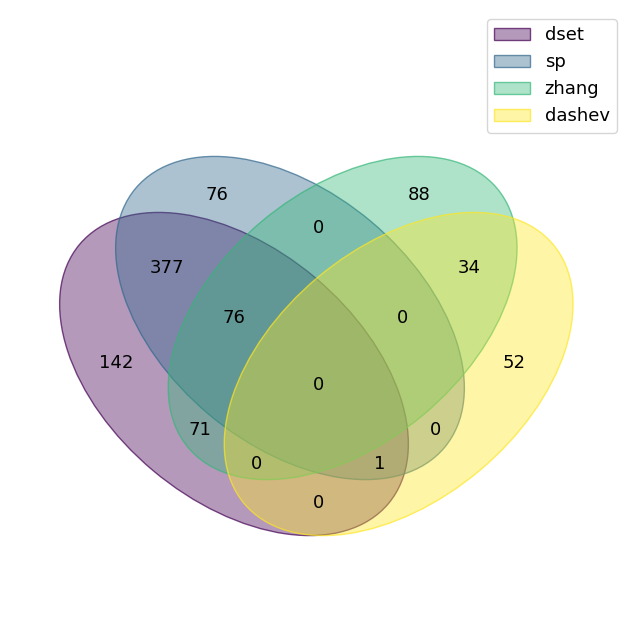

In [94]:
from venn import venn

venn(
    {
        "dset": set(df["acc_id"].to_list()),
        "sp": set(uids),
        "zhang": set(zhang_uids),
        "dashev": set(dashev_uids),
    }
)

## Statistics

In [132]:
def copy_df(df):
    df.index = df.index.fillna("NA")
    pd.io.clipboards.to_clipboard(df.to_markdown(), excel=False)
    print(df)

In [154]:
df["data_origin"].value_counts(dropna=False)

original             802
genomic              152
paper_RituChandna    119
paper_zhang           30
Name: data_origin, dtype: int64

In [155]:
# Entries found in UniProt
res = df["db"].value_counts(dropna=False)
copy_df(df=res)

NA    992
SP     70
TR     41
Name: db, dtype: int64


In [68]:
# number of UniProt accession IDs with a 100% sequence match
res = df["acc_id"].str.split(",").str.len().value_counts(dropna=False)
copy_df(df=res)

1.0    739
NA     189
2.0     22
3.0      3
5.0      1
Name: acc_id, dtype: int64


## Sequences that have more than one UniProt Accession ID

In [ ]:
df.loc[df["acc_id"].str.split(",").str.len() > 1, :]

In [141]:
# entries that come from genomic that found a 100% match in UniProt
res = df.loc[df["data_origin"] == "genomic", "db"].value_counts(dropna=False)
copy_df(df=res)

TR    78
NA    61
SP    13
Name: db, dtype: int64


## Get UniProt full sequence

- [ ] differentiate between chain and signal sequence

In [ ]:
import numpy as np

df[df["name"].isna()]
# df.loc[df["name"] == "-", "name"] = np.nan

In [405]:
import json
import numpy as np

uniprot_dir = Path("uniprot_entry")

data = []
for idx, row in df.iterrows():
    if row["acc_id"] is None:
        if row["name"] == "-":
            row["name"] = np.nan
        data.append(row)
    else:
        acc_ids = row["acc_id"].split(",")
        for acc_id in acc_ids:
            row = row.copy()
            # get data TODO: refractor
            json_path = uniprot_dir / f"{acc_id}.json"
            if json_path.is_file():
                with open(json_path, "r") as json_handler:
                    json_data = json.load(json_handler)
            else:
                response = uniprot_helper.get_uniprot_entry(
                    acc_id=acc_id, format_type="json"
                )
                json_data = response.json()
                with open(json_path, "w") as json_handler:
                    json.dump(json_data, fp=json_handler, indent=4)

            # check if a full sequence exists
            # - features Signal + Chain
            # - different from existing sequence
            # - start with residue M
            features = set()
            if "features" in json_data:
                for feature in json_data["features"]:
                    feature_type = feature["type"]
                    features.add(feature_type)
            if set(["Signal", "Chain"]).issubset(features):
                json_seq = json_data["sequence"]["value"]
                if (json_seq != row["seq"]) and (json_seq.startswith("M")):
                    row["full_seq"] = json_data["sequence"]["value"]

            # TODO: get the mature sequence
            # if "Propeptide" in features:
            #     print(acc_id, features)

            

            # add UniProt info to entries
            row["name"] = name
            row["acc_id"] = acc_id
            row["entry"] = json_data["uniProtkbId"]
            row["prot_evi"] = json_data["proteinExistence"]
            row["annot_score"] = json_data["annotationScore"]
            data.append(row)
new_df = pd.DataFrame(data)
new_df = new_df.drop_duplicates(subset=["seq", "full_seq", "taxon_id"])
# make unique ID
new_df["acc_id"] = new_df["acc_id"].fillna("")
new_df["acc_id"] = new_df["acc_id"] + "__" + new_df["fasta_id"]
new_df["genus"] = new_df["species"].str.split().str[0]

In [406]:
new_names = {
    "Adrenergic toxin": ["Adrenergic toxin"],
    "Alpha-bungarotoxin": ["Alpha-bungarotoxin"],
    "Alpha-elapitoxin": ["Alpha-elapitoxin"],
    "Alpha-neurotoxin": ["Alpha-neurotoxin"],
    "Beta-cardiotoxin": ["Beta-cardiotoxin"],
    "Candiduxin": ["Candiduxin"],
    "Cardiotoxin": ["Cardiotoxin"],
    "Cobrotoxin": ["Cobrotoxin"],
    "Cytotoxin": ["Cytotoxin"],
    "Dendroaspin": ["Dendroaspin"],
    "Erabutoxin": ["Erabutoxin"],
    "Fasciculin": ["Fasciculin"],
    "Frontoxin": ["Frontoxin"],
    "Irditoxin": ["Irditoxin"],
    "Kappa": ["Kappa"],
    "Long neurotoxin": ["Long neurotoxin"],
    "Ly6": ["Ly6", "Ly-6", "Lymphocyte antigen 6", "Prostate stem cell antigen"],
    "Mambalgin": ["Mambalgin"],
    "Micrurotoxin": ["Micrurotoxin"],
    "Mipartoxin": ["Mipartoxin"],
    "Muscarinic": ["Muscarinic"],
    "Neurotoxin": ["Neurotoxin"],
    "Probable weak neurotoxin": ["Probable weak neurotoxin"],
    "Pseudonajatoxin": ["Pseudonajatoxin"],
    "Short neurotoxin": ["Short neurotoxin"],
    "Synergistic-like venom protein": ["Synergistic-like venom protein"],
    "3FTx": [
        "Three finger toxin",
        "Three-finger toxin",
        "Toxin 3FTx",
        "Toxin",
    ],
    "Toxin_TOLIP": ["Toxin_TOLIP"],
    "Three-finger hemachatoxin": ["Three-finger hemachatoxin"],
    "Weak neurotoxin": ["Weak neurotoxin"],
    "Weak toxin": ["Weak toxin"],
}

# extract protein activity from protein name
new_df["new_name"] = new_df["name"]
for new_name, old_name_lst in new_names.items():
    for old_name in old_name_lst:
        new_df.loc[
            new_df["name"].str.contains(old_name, na=False), "new_name"
        ] = new_name

In [402]:
new_df.loc[new_df["new_name"].isin(["Ly6"]), ["data_origin"]].value_counts()

data_origin
genomic        29
dtype: int64

In [398]:
col_data = new_df.pop("acc_id")
new_df.insert(loc=0, column="acc_id", value=col_data)

csv_file = Path("../3FTx/3FTx.csv")
fasta_file = Path("../3FTx/3FTx.fasta")
fasta_file_full_seq = Path("../3FTx/3FTx_full.fasta")
new_df.to_csv(csv_file, index=False)
with open(fasta_file, "w") as fasta_handler:
    for _, row in new_df.iterrows():
        fasta_handler.write(f">{row['acc_id']}\n")
        fasta_handler.write(f"{row['seq']}\n")
with open(fasta_file_full_seq, "w") as fasta_handler:
    for _, row in new_df.dropna(subset="full_seq").iterrows():
        fasta_handler.write(f">{row['acc_id']}\n")
        fasta_handler.write(f"{row['full_seq']}\n")


# import h5py

# esm = "../3FTx_full/3FTx_esm2.h5"
# esm_h5 = "../3FTx_full/3FTx_esm2_.h5"
# csv_ = "../3FTx_full/3FTx_.csv"
# id_tracker = dict()
# with h5py.File(esm, "r") as hdf, h5py.File(esm_h5, "w") as hdf_new:
#     for uid, emb in hdf.items():
#         fasta_id = new_df.loc[new_df["acc_id"] == uid, "fasta_id"].values[0]
#         id_tracker[fasta_id] = id_tracker.setdefault(fasta_id, 0) + 1
#         fasta_id = f"{fasta_id}_{id_tracker[fasta_id]}"
#         new_df.loc[new_df["acc_id"] == uid, "fasta_id"] = fasta_id
#         hdf_new.create_dataset(name=fasta_id, data=emb)

# col_data = new_df.pop("fasta_id")
# new_df.insert(loc=0, column="fasta_id", value=col_data)
# new_df.to_csv(csv_, index=False)

## Add french data

In [27]:
excel_french = Path("raw/3FTs vs receptor dec12.xlsx")
df = pd.read_excel(excel_french, engine="openpyxl")
df.dropna(subset="Groups", inplace=True)
df.drop(columns="SwissProt #", inplace=True)
df = df.reset_index(drop=True)
df.head(2)

/usr/local/anaconda3/envs/protspace3d/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Uniprot #,Entry,Name,Venom,Receptor,Subtype specificity,Activity,Alternative names,Number of CC bonds,PDB code,Referent,Groups,Representative
0,P0C1Y9,3SE1_DENAN,Fasciculin 1,Dendroaspis angusticeps,Acetylcholinesterase (AChE),NaN,Allosteric inhibitor,"Fas1, Fasciculin-I , Fas-I,",4,1FAS,Pascale,1.0,NaN
1,P0C1Z0,3SE2_DENAN,Fasciculin 2,Dendroaspis angusticeps,Acetylcholinesterase (AChE),NaN,Allosteric inhibitor,"Fas2, Fasciculin-II , Fas-II, toxin F-VII",4,1FSC,Pascale,1.0,1.0


In [39]:
french_uid = set(df["Uniprot #"].dropna().to_list())
your_uid = set(new_df["acc_id"].to_list())
new = french_uid - your_uid

In [40]:
", ".join(new)

'P0DQH3, P60675, P0DQH4'

<AxesSubplot: >

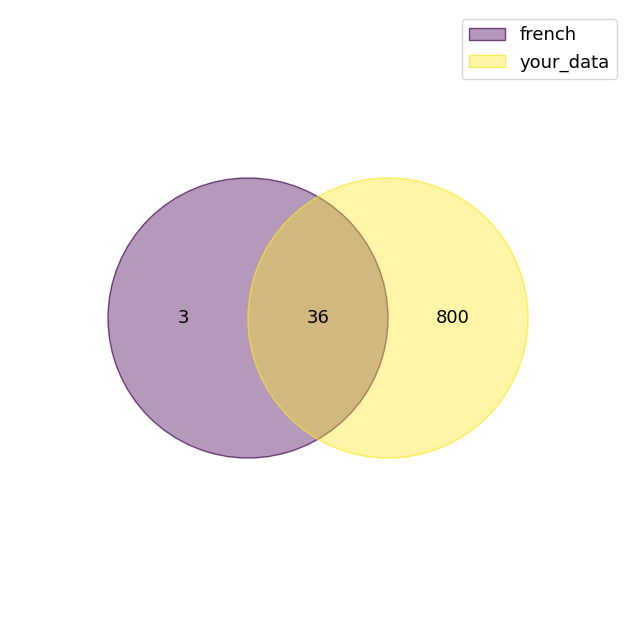

In [38]:
import venn

venn_data = {"french": set(french_uid), "your_data": set(your_uid)}
venn.venn(venn_data)

In [4]:
df = df.drop(columns="SwissProt #")
df = df.reset_index(drop=True)
df.loc[df["Representative"].isna(), "Representative"] = False
df.loc[df["Representative"] == 1.0, "Representative"] = True
df["Representative"] = df["Representative"].astype(bool)
df_new = df.copy()
df_new.head(2)

/usr/local/anaconda3/envs/protspace3d/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Uniprot #,Entry,Name,Venom,Receptor,Subtype specificity,Activity,Alternative names,Number of CC bonds,PDB code,Referent,Groups,Representative
0,P0C1Y9,3SE1_DENAN,Fasciculin 1,Dendroaspis angusticeps,Acetylcholinesterase (AChE),NaN,Allosteric inhibitor,"Fas1, Fasciculin-I , Fas-I,",4,1FAS,Pascale,1.0,False
1,P0C1Z0,3SE2_DENAN,Fasciculin 2,Dendroaspis angusticeps,Acetylcholinesterase (AChE),NaN,Allosteric inhibitor,"Fas2, Fasciculin-II , Fas-II, toxin F-VII",4,1FSC,Pascale,1.0,True


### Get sequences with UniProt Identifier

In [5]:
# entry names with no UniprotID
na_row_names = df_new.loc[df_new["Uniprot #"].isna(), "Name"].values
print(na_row_names)

# drop rows with NA UniprotID
df_new = df_new.loc[df_new["Uniprot #"].notna()]

['Neurotoxin II' 'Muscarinic toxin 5' 'FS2']


In [6]:
# List of Uniprot identifiers
uniprot_ids = df_new["Uniprot #"].values

# Set the URL for the request
url = (
    "https://rest.uniprot.org/uniprotkb/stream?compressed=false&format=fasta&query="
    + "%20OR%20".join(uniprot_ids)
)

# Send the request to Uniprot
response = requests.get(url).text

In [7]:
# save response to FASTA file
seq, header = "", ""
flag = False
with open(fasta_new_path, "w") as out:
    for line in response.split("\n"):
        line = line.strip()
        if line.startswith(">"):
            if seq and flag:
                out.write(f"{seq}\n")
            header = line.split("|")[1]
            if header in uniprot_ids:
                flag = True
                out.write(f">{header}\n")
                seq = ""
            else:
                flag = False
        elif flag:
            seq += line
    if flag:
        out.write(f"{seq}\n")

## Read-in and parse old data

- remove `>` from Alphabet column
- remove entries having `snake genomics` in column `Major group`
- remove columns with predictions
- extract Uniprot ID (what is possible)
- add protein sequence to CSV file
  - sequences "AAAAAAAAKU" and "AAAAAAAAKT" have no entries in the CSV file?


<!-- - extract sews Figure 1 (3C): https://click.endnote.com/viewer?doi=10.1096%2Ffba.1027&token=WzEzMzUzNzAsIjEwLjEwOTYvZmJhLjEwMjciXQ.P2pjnkkZxmPJrOo-8_f_xWlyKvk
(Long-chain) -->

### BLAST in UniProt - results 100% match

TODO:
- [ ] from all three FASTA files extract all headers, sequences, and taxas
  - [ ] check for duplicated headers
  - [ ] check for duplicated sequences
- [ ] Get all UniProt IDs
  - [ ] extract UniProt IDs from header
  - [ ] BLAST UniProt for 100% sequence using sequence and taxa
    - [ ] Write soffisticated Python scripts
  - [ ] store all found IDs imediatly to a file, thereby they dio not get searched again if rerun
- [ ] Specify data_origin
- [ ] Specify gene_name/prot_name (3FTx / Ly6)
- [ ] Final CSV file contains: acc_id, data_origin, taxa, taxa_id, seq, signal_seq, active_seq, prot_name

### Quick and dirty CSV merge

In [46]:
df = df_old.copy()
df = df.drop(columns=["Alphabeticode"])
df = df.reset_index(drop=True)

df1 = df_new.copy()
df1 = df1.rename(columns={"Uniprot #": "Name in fasta"})
df1["Major group"] = "3FTx_new"
df1 = df1.reset_index(drop=True)

In [47]:
colname_id = "Name in fasta"
# df = pd.merge(left=df, right=df1, on=colname_id, how="outer")
df = pd.concat([df, df1])
colidx = df.pop(colname_id)
df.insert(0, colname_id, colidx)
df.to_csv(csv_final, index=False)
df.head(2)

,Name in fasta,Original fasta header,Major group,Evolutionary order,Species,Major taxon,Entry,Name,Venom,Receptor,Subtype specificity,Activity,Alternative names,Number of CC bonds,PDB code,Referent,Groups,Representative
0,Cbivi_3FTx_000,Cbivi_3FTx_000,3FTx,Basal,Calliophis bivirgatus,Elapidae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Erythrolamprus_poecilogyrus_A7X3M9,Erythrolamprus_poecilogyrus_A7X3M9,3FTx,Basal,Erythrolamprus poecilogyrus,Colubridae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Clean-up CSV
- get uniprot ID
  - last element of `Name in fasta` column -> or use `Original fasta header`?
  - get uniprot ID if it starts with G...
  - if it doesn't start with unigeneXXX
  - if something like: `353sp|C0HK` -> 10 char long extract identifier from `Original fasta header` (second entry when split with `|`)
  - if it is at least 5 charcters long
  - check if it can be found in uniprot

In [27]:
df = df_old.copy()
df = df.drop(columns=["Alphabeticode"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 32 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   TM prediction                               991 non-null    object
 1   Cell localisation prediction                991 non-null    object
 2   Original fasta header                       991 non-null    object
 3   Name in fasta                               991 non-null    object
 4   Name (existing or suggested)                991 non-null    object
 5   Major group                                 991 non-null    object
 6   Genomic toxins                              27 non-null     object
 7   Preliminary cysteine group                  991 non-null    object
 8   Evolutionary order                          991 non-null    object
 9   Novel function                              65 non-null     object
 10  Species                   

## Report
- French guys dset (`3FTs vs receptor dec12.xlsx`):
  - Three entry names had no UniProtID and were removed: 'Neurotoxin II', 'Muscarinic toxin 5', 'FS2'
- Ivan + MH dset:
  - remove dashes `-` in seqs
  - extract UniProt identifier where possible
  - same ID, different sequence?
    ```
    >Walterinnesia_aegyptia_C0HKZ8
    MECYKCGVSGCHLKITCSAEEKFCYKWQDKISNERWLGCAKTCTEEDTWRVYNSCCTTNLCNI
    >353sp|C0HK
    >sp|C0HKZ8|3NOJ_WALAE Actiflagelin OS=Walterinnesia aegyptia OX=64182 PE=1 SV=2
    MECYKCGVSGCHLKITCSAEEKFCYKWRDKISNERWLGCAKTCTEENTWRVYNSCCTTNLCNP
    ```
    - according to UniProt history one is the old sequence version


  - Given that the **Original fasta header** column in the `SM_table.csv` file had unique names the FASTA file (`3and6_current_alignment.fasta`) was updated with those
  - `3FTs vs receptor dec12.xlsx`
- Clean up CSV
  - Name in fasta
    - What is 3FTx_000, 3FTx_05, ...

In [72]:
seq1 = "MECYKCGVSGCHLKITCSAEEKFCYKWQDKISNERWLGCAKTCTEEDTWRVYNSCCTTNLCNI"
seq2 = "MECYKCGVSGCHLKITCSAEEKFCYKWRDKISNERWLGCAKTCTEENTWRVYNSCCTTNLCNP"
for idx, (s1, s2) in enumerate(zip(seq1, seq2), 1):
    if s1 != s2:
        print(idx, s1, s2)

28 Q R
47 D N
63 I P
